In [55]:
# aim : predict earnings for foreign movies in the US
from bs4 import BeautifulSoup
import requests
import pandas as pd
import time
import scraping
import constants
import os
import numpy as np
import re
import seaborn as sns
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from seaborn import plt

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection  import KFold
from sklearn import preprocessing

import scipy.stats as stats
import patsy
import statsmodels.api as sm
%matplotlib inline

In [56]:
df = pd.read_csv('data/data_salary.csv', index_col=0)

In [57]:
df = df.dropna()

In [58]:
def basic_plot(x_col, y_col, df, ax, x_label=None, y_label=None):
    if not x_label:
        x_label = x_col 
    if not y_label:
        y_label = y_col
    ax.scatter(df[x_col], df[y_col], label=y_label)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title('{} vs. {}'.format(x_label, y_label))
    

# I want to investigate, whether there's a stronger PER correlation for players drafted 20 or higher. 

In [59]:
df = df[df.draft_rank < 11]

In [60]:
# The numerical columns
x_columns = ['ast', 'ast_per_g', 'blk', 'draft_rank', 'draft_year',
       'end_age', 'fg', 'fg3', 'fg3_pct', 'fg3a', 'fg_pct', 'fga', 'ft',
       'ft_pct', 'fta', 'g', 'height_in', 'mp', 'mp_per_g',
       'no_of_seasons', 'pts', 'pts_per_g', 'reach_in',
       'start_age', 'stl', 'trb_per_g', 'weight_lb', 'wingspan_in',
        'adjusted_salary',] # need to add shoot and position
def preprocess(df, cols = None, intercept=False):
    if not cols:
        cols = x_columns
    y_data = df['per']
    X_data = df[cols]
    X_sc=preprocessing.normalize(X_data, axis=0, norm='max')
    # turn back in DF
    X_sc=pd.DataFrame(X_sc)
    X_sc.columns = cols
    X_data.columns = cols
    return X_sc, y_data, X_data

In [61]:
folds = 4
alpha_list=[1e-5,1e-3,1e-2, 1e-1,1, 10, 1e4]
def pick_alpha(fold, X, y, alphas=None):
    if not alphas:
        alphas = alpha_list
    kf = KFold(n_splits=fold)

    all_scores=[]


    for train, test in kf.split(X):
        x_train=X.iloc[train]
        y_train=y.iloc[train]
        x_test=X.iloc[test]
        y_test=y.iloc[test]
        mse_score=[]
        for a in alphas:
            est=Lasso(alpha=a)
            est.fit(x_train,y_train)
            mse=np.mean((y_test-est.predict(x_test))**2)
            mse_score.append(mse)
        all_scores.append(mse_score)
    plt.figure(figsize=(8,6))
    plt.legend()
    for i in range(fold):
        plt.plot(np.log10(alphas), all_scores[i],label = 'cv %s'%i)
    # Calculate the mean and plot it
    mean = np.array(all_scores).mean(axis=0).tolist()
    plt.plot(np.log10(alphas), mean, label = 'mean')
    plt.legend()
    plt.xlabel('alphas')
    plt.ylabel('MSE')
    plt.ylim(0)
    plt.show()

# First Iteration

/Users/josephinetirtanata/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/josephinetirtanata/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


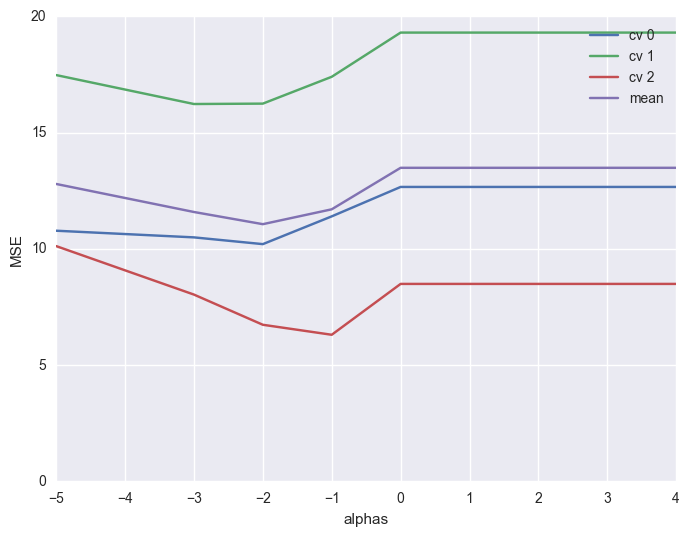

In [76]:
X_sc, y_data, X_data = preprocess(df)
pick_alpha(3, X_sc, y_data)

# Alpha
- It seems like 1e-2 is the best value
- Now, let's take a look at the strongest features

In [77]:
# Take a quick look at our strongest features
def find_features(alpha, X, y, columns):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    est=Lasso(alpha=alpha)
    est.fit(X_train,y_train)
    zipped=zip(columns,est.coef_)
    features=sorted(zipped,key = lambda t: t[1],reverse=True)
    print(est.score(X_test, y_test))
    return [x for x in features if x[1] != 0] ,est
def print_summary (features, X, y):
    features = [x[0] for x in features]
    X_features = X[features]
    lsm = sm.OLS(y,X_features)
    fit = lsm.fit()
    fit.summary()


In [78]:
features,est = find_features(1e-2, X_sc, y_data, X_sc.columns)

0.331541946645


In [79]:
features

[('fg_pct', 9.913646044480938),
 ('ft', 3.1499969317909682),
 ('stl', 2.9714319769526316),
 ('ast_per_g', 2.846920148069171),
 ('blk', 1.3851685019102142),
 ('trb_per_g', 0.96997310230807909),
 ('fg3a', 0.52740293160494822),
 ('fg3_pct', -0.15841193365287806),
 ('ft_pct', -0.33120061565321018),
 ('g', -1.0245924060789822),
 ('weight_lb', -2.0950015332721619),
 ('mp', -2.4027502579242892),
 ('mp_per_g', -2.6812912734644891),
 ('adjusted_salary', -3.2544740980933744),
 ('draft_rank', -4.6050020466203767),
 ('end_age', -19.345913879765511)]

In [80]:
def print_coef(f, coef):
    zipped=zip(f,coef)
    features=sorted(zipped,key = lambda t: t[1],reverse=True)
    for (a,b) in features:
        print ('{}\t\t\t{}'.format(a,b))



## Scaled

In [84]:
rcv = RidgeCV(cv=10)
f = [x[0] for x in features]
if 'adjusted_salary' in f:
    f.remove('adjusted_salary')
X_sc, y_data, X_data = preprocess(df, cols=f)
xtrain, xtest, ytrain, ytest = train_test_split(X_data, y_data, test_size=0.3)

rcv.fit(X_data, y_data)
rcv.score(xtest, ytest)


0.37280004160164937

In [85]:
rcv.intercept_

33.554058246992035

In [86]:
print_coef(f, rcv.coef_)

fg_pct			16.000276311295455
ft_pct			1.1155415578491392
ast_per_g			0.497665028530547
trb_per_g			0.24656443470084416
stl			0.013235158972832003
blk			0.006352721804229641
ft			0.005681194201305786
fg3a			0.0005313957871219492
mp			-0.0006675694307882004
g			-0.010537821272180174
weight_lb			-0.019844403855451647
fg3_pct			-0.0796126906910424
mp_per_g			-0.10908918557198034
draft_rank			-0.2762941531448819
end_age			-1.09109009992719


## Scaled

In [87]:
rcv = RidgeCV(cv=10)

xtrain, xtest, ytrain, ytest = train_test_split(X_sc, y_data, test_size=0.3)
rcv.fit(X_sc, y_data)
rcv.score(xtest, ytest)


0.21000764100396296

In [88]:
print_coef(f, rcv.coef_)

fg_pct			5.228583873247195
ft			3.201105812602215
ast_per_g			2.98020509357757
stl			2.859271858536183
trb_per_g			2.201229021318222
blk			1.6350498180162323
ft_pct			0.022636842198451305
fg3_pct			-0.08869272914415459
fg3a			-0.6478192668529761
mp_per_g			-1.649318865296802
weight_lb			-1.8408486757145208
mp			-2.5465454966370107
g			-2.5785795210721676
draft_rank			-3.452570550785184
end_age			-5.493111975609643


In [42]:
rcv.intercept_

23.014525502365423

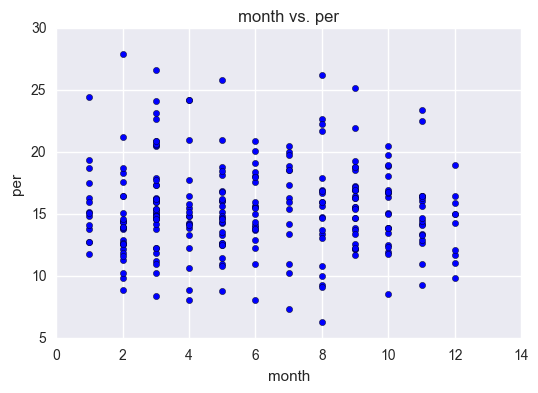

In [44]:
fig, ax = plt.subplots(1,1)
basic_plot('month', 'per', df, ax)

In [89]:
df[df.per > 20]

,ast,ast_per_g,blk,college,draft_rank,draft_year,end_age,fg,fg3,fg3_pct,...,trb_per_g,weight_lb,wingspan_in,salary,position,birthday,shoot,inflation,adjusted_salary,month
0,288.0,2.3,481.000000,Wake Forest University,1.0,1997.0,20.0,790.0,17.0,0.321000,...,12.3,213.907276,83.254228,2967840.0,Center and Power Forward,1976-04-25,Right,1.50,4451760.0,4.0
90,51.0,0.9,113.000000,Duke University,1.0,1999.0,19.0,355.0,0.0,0.326576,...,8.9,260.000000,89.500000,3375960.0,Power Forward and Center,1979-03-11,Right,1.44,4861382.4,3.0
246,77.0,2.2,30.000000,Syracuse University,3.0,2003.0,18.0,277.0,56.0,0.337000,...,10.0,233.000000,84.000000,3229200.0,Small Forward and Power Forward,1984-05-29,Right,1.30,4197960.0,5.0
247,38.0,1.2,67.000000,Georgia Institute of Technology,4.0,2003.0,18.0,168.0,22.0,0.478000,...,9.0,225.000000,87.500000,2911320.0,Center and Power Forward,1984-03-24,Left,1.30,3784716.0,3.0
248,255.0,3.9,79.000000,Marquette University,5.0,2003.0,21.0,474.0,32.0,0.333000,...,6.5,212.000000,82.750000,2636400.0,Shooting Guard and Point Guard,1982-01-17,Right,1.30,3427320.0,1.0
307,395.0,6.3,13.000000,Wake Forest University,4.0,2005.0,19.0,278.0,86.0,0.470000,...,3.9,178.000000,76.250000,3144240.0,Point Guard,1985-05-06,Right,1.23,3867415.2,5.0
341,34.0,0.6,97.000000,University of Texas at Austin,2.0,2006.0,20.0,276.0,0.0,0.326576,...,8.2,234.000000,88.750000,4027320.0,Power Forward and Center,1985-07-19,Right,1.19,4792510.8,7.0
384,46.0,1.3,67.000000,University of Texas at Austin,2.0,2007.0,18.0,306.0,82.0,0.404000,...,11.1,215.000000,88.750000,4171200.0,Small Forward and Shooting Guard,1988-09-29,Right,1.16,4838592.0,9.0
389,37.0,1.0,65.000000,University of North Carolina,8.0,2007.0,19.0,228.0,0.0,0.326576,...,6.2,200.000000,87.750000,2323080.0,Power Forward and Center,1987-10-05,Left,1.16,2694772.8,10.0
428,191.0,2.5,8.000000,"University of California, Los Angeles",4.0,2008.0,19.0,230.0,35.0,0.354000,...,2.4,192.000000,79.750000,3493680.0,Point Guard,1988-11-12,Right,1.11,3877984.8,11.0
